In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Dense, Dropout, Flatten, LSTM, Multiply, GlobalAveragePooling1D, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [97]:
data_path = 'plant_health_data.csv'  # Replace with actual path
data = pd.read_csv(data_path)

# Features and Target
X = data[[  # Replace with the correct column names
    'Soil_Moisture', 'Ambient_Temperature', 'Soil_Temperature', 'Humidity',
    'Light_Intensity', 'Soil_pH', 'Nitrogen_Level', 'Phosphorus_Level',
    'Potassium_Level', 'Chlorophyll_Content', 'Electrochemical_Signal'
]]
y = data['Plant_Health_Status']

# Encode target labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape for CNN input
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [98]:
def se_block(input_tensor, ratio=16):
    filters = input_tensor.shape[-1]
    se = GlobalAveragePooling1D()(input_tensor)
    se = Dense(filters // ratio, activation='relu')(se)
    se = Dense(filters, activation='sigmoid')(se)
    return Multiply()([input_tensor, se])

In [99]:
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))

# CNN Block 1
x = Conv1D(64, kernel_size=3, activation='relu', padding='same')(input_layer)
x = MaxPooling1D(pool_size=2)(x)
x = se_block(x)

# CNN Block 2
x = Conv1D(32, kernel_size=3, activation='relu', padding='same')(x)
x = MaxPooling1D(pool_size=2)(x)
x = se_block(x)

# Flatten before LSTM
x = Flatten()(x)
x = Reshape((1, -1))(x)  # Reshape for LSTM input

# LSTM Layers
x = LSTM(128, return_sequences=True)(x)
for _ in range(5):  # Total 6 LSTM layers
    x = LSTM(128, return_sequences=True, dropout=0.2)(x)

# Fully Connected Layer
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1)(x)  # Regression output

model = Model(inputs=input_layer, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])


In [100]:
early_stopping = EarlyStopping(
    monitor='val_loss',  # ตรวจสอบค่า loss ใน validation set
    patience=5,          # หยุดถ้า val_loss ไม่ดีขึ้นใน 5 รอบ
    restore_best_weights=True  # โหลด weights ที่ดีที่สุดกลับมา
)

history = model.fit(
    X_train, y_train, 
    epochs=20,
    batch_size=32, 
    validation_split=0.2, 
    verbose=1
)

Epoch 1/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 23s 120ms/step - loss: 1.6098 - mae: 1.0497 - val_loss: 0.6409 - val_mae: 0.6767
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.6286 - mae: 0.6479 - val_loss: 0.5590 - val_mae: 0.5993
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.5663 - mae: 0.6131 - val_loss: 0.5554 - val_mae: 0.5810
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.5941 - mae: 0.6355 - val_loss: 0.5550 - val_mae: 0.5846
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.5878 - mae: 0.6283 - val_loss: 0.5536 - val_mae: 0.5660
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.5827 - mae: 0.6277 - val_loss: 0.5509 - val_mae: 0.5655
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.5948 - mae: 0.6389 - val_loss: 0.4305 - val_mae: 0.5491
Epoch 8/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.4708 - mae: 0.5818 - val_loss: 0.3840 - val_mae: 0.4896
Epoch 9/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.4

30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 281ms/step
     Set        R²       MAE       MBE      RMSE  Learning Rate
0  Train  0.633011  0.338198 -0.076744  0.453852          0.001
1   Test  0.589305  0.387256 -0.101982  0.510670          0.001


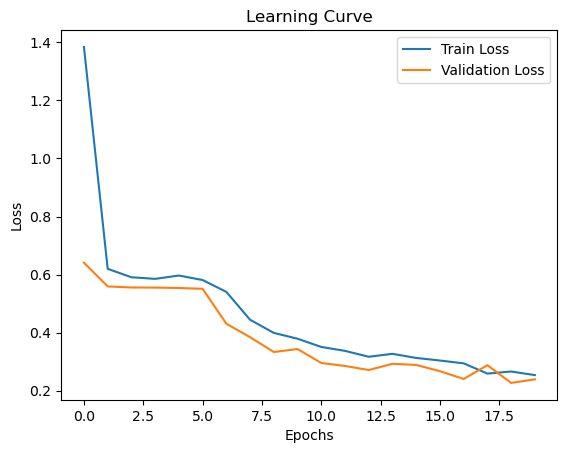

In [101]:
def mean_bias_error(y_true, y_pred):
    return np.mean(y_pred - y_true)

# Predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Metrics Calculation
results = {
    "Set": ["Train", "Test"],
    "R²": [
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)
    ],
    "MAE": [
        mean_absolute_error(y_train, y_train_pred),
        mean_absolute_error(y_test, y_test_pred)
    ],
    "MBE": [
        mean_bias_error(y_train, y_train_pred),
        mean_bias_error(y_test, y_test_pred)
    ],
    "RMSE": [
        np.sqrt(mean_squared_error(y_train, y_train_pred)),
        np.sqrt(mean_squared_error(y_test, y_test_pred))
    ],
    "Learning Rate": [0.001, 0.001]  # Specify Learning Rate used
}

# Display Results
results_df = pd.DataFrame(results)
print(results_df)

# =============================
# Save Results
# =============================
results_df.to_csv("model_evaluation_results.csv", index=False)

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.show()